In [214]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC 

In [215]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [216]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [217]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [218]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [219]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [309]:
epoch

<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'b-f1-pic': 60
 'b-f1-snd': 60
 'b-f1-spk': 60
 'b-f1-wrd': 100
 'b-f2-pic': 60
 'b-f2-snd': 60
 'b-f2-spk': 61
 'b-f2-wrd': 100
 'b-tg-pic': 80
 'b-tg-snd': 40
 'b-tg-spk': 60
 'b-tg-wrd': 100
 'congruent': 320
 'correct': 231
 'f-f1-pic': 60
 'f-f1-snd': 40
 'f-f1-spk': 80
 'f-f1-wrd': 60
 'f-f2-pic': 60
 'f-f2-snd': 40
 'f-f2-spk': 80
 'f-f2-wrd': 59
 'f-tg-pic': 20
 'f-tg-snd': 40
 'f-tg-spk': 80
 'f-tg-wrd': 100
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'trail_start': 640>

In [220]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim .events.shape

(5424, 3)

In [221]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [222]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [223]:
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVNN" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

[array([27806,     0,   100]),
 array([27931,     0,   100]),
 array([28060,     0,   100]),
 array([28521,     0,   100]),
 array([28646,     0,   100]),
 array([28775,     0,   100]),
 array([29292,     0,   100]),
 array([29417,     0,   100]),
 array([29546,     0,   100]),
 array([29826,     0,   100]),
 array([29951,     0,   100]),
 array([30080,     0,   100]),
 array([30752,     0,   100]),
 array([30876,     0,   100]),
 array([31006,     0,   100]),
 array([31406,     0,   100]),
 array([31531,     0,   100]),
 array([31660,     0,   100]),
 array([31940,     0,   100]),
 array([32065,     0,   100]),
 array([32194,     0,   100]),
 array([32646,     0,   100]),
 array([32771,     0,   100]),
 array([32900,     0,   100]),
 array([33383,     0,   100]),
 array([33508,     0,   100]),
 array([33637,     0,   100]),
 array([35463,     0,   100]),
 array([35587,     0,   100]),
 array([35717,     0,   100]),
 array([36328,     0,   100]),
 array([36453,     0,   100]),
 array([

In [328]:
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [329]:
type(test)

mne.epochs.EpochsFIF

In [316]:
epochWnewStim.get_data().shape

(5424, 129, 180)

In [326]:
type(epochWnewStim)

mne.epochs.EpochsFIF

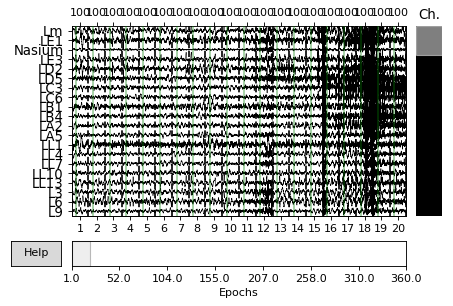

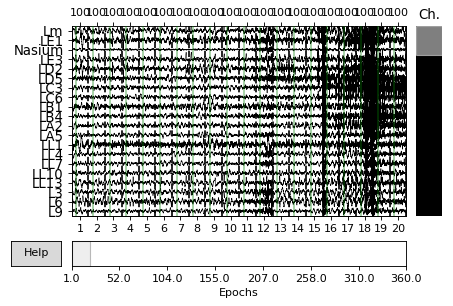

In [335]:
test.plot()

In [332]:
test.get_data().shape

(360, 129, 180)

In [336]:
from sklearn.cross_validation import train_test_split
features_data = test.get_data()
target_V_vs_A = test.events[:,-1]

print("shape of data",features_data.shape)
print("shape of target array",target_V_vs_A.shape)




shape of data (360, 129, 180)
shape of target array (360,)


In [350]:
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression())

cv = StratifiedKFold(n_splits = 10, shuffle=True)
#y_preds = np.empty(len(target_V_vs_A))
score = []
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

#i = 0
for train,test in cv.split(features_data,target_V_vs_A):
    X_train = features_data[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = features_data[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    clf.fit(X_train,y_train)
    #print("shape of 2D data",Vectorizer().fit_transform(X_train).shape)
    proba = clf.predict_proba(X_test)
    print(proba)
    y_preds = clf.predict(X_test)
    y_preds = np.array(y_preds)
    threshold,visual,audio = 100,0,1
    binary_y_preds = np.where(y_preds > threshold, audio,visual)
    #print(binary_y_preds)
    #print(y_preds)
    y_testNP = np.array(y_test)
    #threshold,visual,audio = 100,0,1
    binary_y_test = np.where(y_testNP > threshold, audio,visual)
    #print(binary_y_test)
    
    #print(set(y_test))
#     fpr,tpr,threshold = metrics.roc_curve(y_test,binary_y_preds)
#     tprs.append(interp(mean_fpr,fpr,tpr))
#     tprs[-1][0] = 0.0
#     roc_auc = metrics.auc(fpr,tpr)
#     aucs.append(roc_auc)
    
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#     i += 1
#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#              label='Chance', alpha=.8)

#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
#     plt.plot(mean_fpr, mean_tpr, color='b',
#              label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#              lw=2, alpha=.8)

#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                      label=r'$\pm$ 1 std. dev.')

#     plt.xlim([-0.05, 1.05])
#     plt.ylim([-0.05, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()
    
    score.append(clf.score(X_test,y_test))
    
    





[[9.96492540e-01 3.50746046e-03]
 [9.18294889e-01 8.17051108e-02]
 [9.52807699e-01 4.71923010e-02]
 [9.71913940e-01 2.80860596e-02]
 [9.73746381e-01 2.62536194e-02]
 [9.86672590e-01 1.33274099e-02]
 [9.53468487e-01 4.65315128e-02]
 [9.94119550e-01 5.88045028e-03]
 [8.98355508e-01 1.01644492e-01]
 [7.06244469e-01 2.93755531e-01]
 [4.32303840e-01 5.67696160e-01]
 [6.20746569e-01 3.79253431e-01]
 [1.48710326e-01 8.51289674e-01]
 [9.08856106e-01 9.11438937e-02]
 [1.74963993e-01 8.25036007e-01]
 [5.38699987e-02 9.46130001e-01]
 [9.33574401e-01 6.64255986e-02]
 [9.91626923e-01 8.37307734e-03]
 [9.90505155e-01 9.49484462e-03]
 [9.32467455e-01 6.75325452e-02]
 [9.18896594e-01 8.11034058e-02]
 [9.35546120e-01 6.44538803e-02]
 [7.65620153e-01 2.34379847e-01]
 [3.87975941e-01 6.12024059e-01]
 [1.23154068e-01 8.76845932e-01]
 [9.98982701e-01 1.01729902e-03]
 [9.99273796e-01 7.26204228e-04]
 [9.85649919e-01 1.43500809e-02]
 [9.99607758e-01 3.92242370e-04]
 [5.56948765e-01 4.43051235e-01]
 [9.763349

[[0.9198486  0.0801514 ]
 [0.99898322 0.00101678]
 [0.89247654 0.10752346]
 [0.83140077 0.16859923]
 [0.97910635 0.02089365]
 [0.46834342 0.53165658]
 [0.02931136 0.97068864]
 [0.18512107 0.81487893]
 [0.91840513 0.08159487]
 [0.09053597 0.90946403]
 [0.19526531 0.80473469]
 [0.99619647 0.00380353]
 [0.97213284 0.02786716]
 [0.98821762 0.01178238]
 [0.91403003 0.08596997]
 [0.89372072 0.10627928]
 [0.99254601 0.00745399]
 [0.99806323 0.00193677]
 [0.7867633  0.2132367 ]
 [0.48802467 0.51197533]
 [0.9465804  0.0534196 ]
 [0.17439908 0.82560092]
 [0.96300043 0.03699957]
 [0.99642695 0.00357305]
 [0.99822027 0.00177973]
 [0.97700348 0.02299652]
 [0.92677656 0.07322344]
 [0.18307179 0.81692821]
 [0.93023489 0.06976511]
 [0.98690837 0.01309163]
 [0.33789606 0.66210394]
 [0.97863614 0.02136386]
 [0.94449849 0.05550151]
 [0.73263701 0.26736299]
 [0.02320567 0.97679433]
 [0.99307231 0.00692769]]
[[0.98668693 0.01331307]
 [0.99228864 0.00771136]
 [0.95587092 0.04412908]
 [0.97502201 0.02497799]

In [301]:
print(score)

[0.8055555555555556, 0.8333333333333334, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.6111111111111112, 0.7222222222222222, 0.6944444444444444, 0.6944444444444444]


In [302]:
print("mean classification score", np.mean(score))

mean classification score 0.7583333333333334


In [178]:
aaa = Vectorizer().fit_transform(features_data)
aaa.shape


(360, 23220)

In [212]:
df = pd.DataFrame(aaa)

In [213]:
df

,0,1,2,3,4,5,6,7,8,9,...,23210,23211,23212,23213,23214,23215,23216,23217,23218,23219
0,-3.921823e-06,-5.571442e-06,-7.366096e-06,-6.524563e-06,-4.005347e-06,-3.862769e-06,-4.859965e-06,-2.718158e-06,-1.742042e-06,-1.764748e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
1,4.585151e-07,1.334955e-06,1.721369e-06,5.151453e-06,5.680569e-06,5.037848e-06,5.773264e-06,4.190741e-06,2.187261e-06,1.780399e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.445867e-06,-3.173985e-06,-2.885827e-06,-3.581341e-06,-1.680603e-06,-1.934519e-06,-4.541460e-07,-5.035362e-07,4.782355e-07,2.201315e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.445486e-06,-2.589277e-06,-1.189872e-06,-3.303565e-07,5.270368e-07,2.938219e-06,3.698142e-06,3.139596e-06,2.568221e-06,2.410926e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
4,2.077913e-06,-4.561307e-06,-8.878198e-06,-7.208122e-06,-2.337705e-06,-4.857510e-07,9.799401e-07,-1.008280e-06,3.965988e-07,2.658183e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-6.146129e-06,-9.847182e-06,-6.794071e-06,-4.943444e-06,-4.647918e-06,-3.284984e-06,-2.845580e-06,-3.298798e-06,-3.530485e-06,-7.771520e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.716986e-06,3.479391e-06,5.858217e-06,3.656822e-06,3.723697e-06,5.513758e-06,4.253008e-07,-6.206208e-07,-5.964056e-07,-3.299895e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
7,-1.290905e-06,-2.114264e-06,2.794255e-07,2.869302e-06,1.859287e-06,-1.398569e-06,-2.871440e-06,-2.927482e-06,-1.053195e-06,4.657122e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.998460e-06,4.963545e-06,3.714679e-06,2.574560e-06,2.197050e-06,1.708264e-06,-3.167101e-07,1.152561e-06,1.841309e-06,-8.437510e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-5.850758e-06,-4.454986e-06,7.864037e-07,1.603537e-06,1.618401e-07,-1.447479e-06,-1.225500e-06,-4.779112e-07,-2.383629e-06,-4.583182e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0


In [181]:
clf.classes_

array([100, 200])

In [182]:
print(metrics.r2_score(target_test,y_pred))

-0.24401913875598047


array([-4.1920613 , -4.77514058, -0.49106324, -0.22338122,  0.38171083,
        1.74602437, -2.54455606, -2.08286078, -2.95095634, -4.26044356,
       -4.0761867 ,  0.43578667, -2.23397378, -3.57802828, -4.00813011,
       -1.94200906, -3.12121567, -2.13596743,  0.8847367 , -3.21826793,
       -3.13581339, -6.95525329, -5.96633699, -2.35855757,  0.85819578,
       -4.3996523 , -4.3480659 ,  0.63356524, -3.29634454,  3.07940347,
       -0.75305579, -3.27642697, -2.89811734, -1.02155945, -0.8655743 ,
       -0.51790452, -5.10860724, -2.04640956,  1.65945086, -0.72419167,
       -3.39436976, -1.30994811,  0.77474607, -3.85220964,  1.95538628,
       -4.21256811, -7.22996304, -3.43662088, -0.05139956,  1.34315264,
       -3.78605912, -3.88440506, -3.42619506, -0.13859775, -4.69572278,
        1.41365962,  3.00351893, -3.52699453, -0.13780543,  0.87812066,
       -0.9545848 ,  2.67623701, -3.18021571, -7.13119845, -1.43287455,
       -2.62933268, -5.52677051, -2.46194502, -4.69322439, -0.02